In [1]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os

# Add project root to sys.path
sys.path.append("..")

from modules.retrieval.reranker import Reranker

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load all cleaned documents from storage

questions_df = pd.read_csv(
     "../qa_resources/question.tsv"
    ,sep="\t"
)

storage_path = "../storage"
documents = []

for filename in sorted(os.listdir(storage_path)):
    if filename.endswith(".txt.clean"):
        with open(os.path.join(storage_path, filename), "r", encoding="latin-1") as f:
            documents.append(f.read())

print(f"Loaded {len(documents)} documents and {len(questions_df)} questions.")

questions_df['ArticleTitle'].unique()

Loaded 150 documents and 1051 questions.


array(['Abraham_Lincoln', 'Alessandro_Volta', 'Amedeo_Avogadro',
       'Anders_Celsius', 'beetle', 'Calvin_Coolidge', 'Canada', 'duck',
       'Egypt', 'elephant', 'Finland', 'Gerald_Ford', '\\n', 'Ghana',
       'Gray_Wolf', 'Grover_Cleveland', 'Henri_Becquerel', 'Indonesia',
       'Isaac_Newton', 'James_Monroe', 'James_Watt', 'John_Adams',
       'kangaroo', 'leopard'], dtype=object)

In [3]:
questions_df[questions_df['ArticleTitle'] == 'Anders_Celsius']["Question"]


139    Who determined the dependence of the boiling o...
140                             What is named after him?
141                    When did he publish a collection?
142    Is it true that he published a collection in 1...
143    Is it true that thermometer had 100 for the fr...
144               Was Celsius born in Uppsala in Sweden?
145    Was Anders Celsius (November 27, 1701 April 25...
146    Is The Celsius crater on the Moon named after ...
147    Who was the first to perform and publish caref...
148              The Celsius crater on the Moon is what?
149    Is the Celsius crater on the Moon named after ...
150    Had his thermometer 100 for the freezing point...
151              Was Celsius born in Uppsala in Sweden ?
152    Is the Celsius crater on the Moon named after ...
153    Did he not determine the dependence of the boi...
154                     What happened from 1730 to 1744?
155                               What happened in 1745?
Name: Question, dtype: object

In [4]:
query=questions_df[questions_df['ArticleTitle'] == 'Anders_Celsius']["Question"].iloc[0]
query

'Who determined the dependence of the boiling of water with atmospheric pressure?'

In [5]:
# Anders_Celsius
documents = documents[75].split('\n\n')
documents

['Anders_Celsius',
 'Anders Celsius\nThe observatory of Anders Celsius, from a contemporary engraving.\nAnders Celsius (November 27, 1701   April 25, 1744) was a Swedish astronomer.\nCelsius was born in Uppsala in Sweden. He was professor of astronomy at Uppsala University from 1730 to 1744, but traveled from 1732 to 1735 visiting notable observatories in Germany, Italy and France.',
 'At Nuremberg in 1733 he published a collection of 316 observations of the aurora borealis made by himself and others over the period 1716-1732. In Paris he advocated the measurement of an arc of the meridian in Lapland, and in 1736 took part in the expedition organized for that purpose by the French Academy of Sciences, led by the French mathematician Pierre Louis Maupertuis.',
 "Celsius founded the Uppsala Astronomical Observatory in 1741, and in 1742 he proposed the Celsius temperature scale in a paper to the Royal Swedish Academy of Sciences. His thermometer had 100 for the freezing point of water and

In [6]:
# Define reranker types to test
strategies = ['tfidf', 'bow', 'cross_encoder']
results = {}

print(f"Query: {query}")

# Run reranking 
for strategy in strategies:
    reranker = Reranker(type=strategy)
    ranked_docs, ranked_indices, scores = reranker.rerank(query, documents)
    results[strategy] = {"docs": ranked_docs, "scores": scores}


Query: Who determined the dependence of the boiling of water with atmospheric pressure?


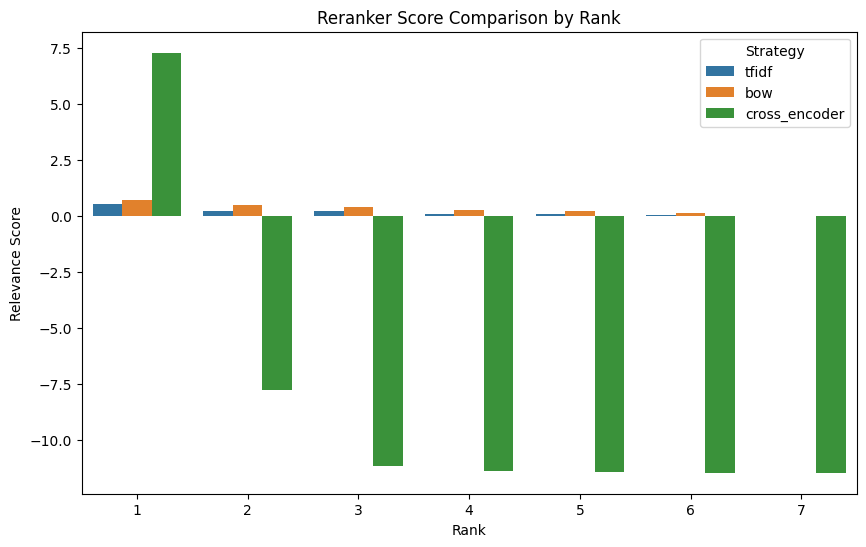

In [7]:
# Format data for plotting
data = []
for strat in strategies:
    for i, (doc, score) in enumerate(zip(results[strat]["docs"], results[strat]["scores"])):
        data.append({
            "Strategy": strat,
            "Rank": i + 1,
            "Score": score,
            "Text": doc
        })

df_plot = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Rank", y="Score", hue="Strategy")
plt.title("Reranker Score Comparison by Rank")
plt.ylabel("Relevance Score")
plt.show()

In [8]:
# Extract rankings 
doc_set = list(set(documents))
ranking_matrix = pd.DataFrame(index=doc_set)

for strategy in strategies:
    reranker = Reranker(type=strategy)
    ranked_docs, _, _ = reranker.rerank(query, documents)
    ranks = {doc: i + 1 for i, doc in enumerate(ranked_docs)}
    ranking_matrix[strategy] = ranking_matrix.index.map(ranks)
ranking_matrix

,tfidf,bow,cross_encoder
The Celsius crater on the Moon is named after him.\n,4,4,7
"Celsius founded the Uppsala Astronomical Observatory in 1741, and in 1742 he proposed the Celsius temperature scale in a paper to the Royal Swedish Academy of Sciences. His thermometer had 100 for the freezing point of water and 0 for the boiling point. The scale was reversed by Carolus Linnaeus in 1745, to how it is today Linnaeus' thermometer .",3,3,2
"In 1744 he died of tuberculosis in Uppsala, and was buried in the Old Uppsala Church.",5,5,5
"Anders Celsius was the first to perform and publish careful experiments aiming at the definition of an international temperature scale on scientific grounds. In his Swedish paper ""Observations of two persistent degrees on a thermometer"" he reports on experiments to check that the freezing point is independent of latitude (and of atmospheric pressure). He determined the dependence of the boiling of water with atmospheric pressure (in excellent agreement with modern data). He further gave a rule for the determination of the boiling point if the barometric pressure deviates from a certain standard pressure History of the Celsius temperature scale .",1,1,1
Anders_Celsius,7,7,6
"Anders Celsius\nThe observatory of Anders Celsius, from a contemporary engraving.\nAnders Celsius (November 27, 1701 April 25, 1744) was a Swedish astronomer.\nCelsius was born in Uppsala in Sweden. He was professor of astronomy at Uppsala University from 1730 to 1744, but traveled from 1732 to 1735 visiting notable observatories in Germany, Italy and France.",6,6,4
"At Nuremberg in 1733 he published a collection of 316 observations of the aurora borealis made by himself and others over the period 1716-1732. In Paris he advocated the measurement of an arc of the meridian in Lapland, and in 1736 took part in the expedition organized for that purpose by the French Academy of Sciences, led by the French mathematician Pierre Louis Maupertuis.",2,2,3


### Analysis: "Who determined the dependence of the boiling of water with atmospheric pressure?"

#### 1. Cross-Encoder
- Ranked the correct answer paragraph first, demonstrating strong semantic understanding.
- Successfully linked "determined the dependence" with experimental work on "boiling of water" and "atmospheric pressure".
- Ideal for precision-critical scenarios and deeper contextual understanding.

#### 2. TF-IDF
- Ranked the correct paragraph first as well.
- Lexical overlap with "boiling", "pressure", and "dependence" helped match the query correctly.
- Performs well when question phrasing matches document phrasing closely.
- Vulnerable to false positives on similar keywords (e.g., temperature vs. pressure) in longer documents.

#### 3. BoW
- Also ranked the correct paragraph first — good performance in this short, focused document.
- However, its reliance on word frequency over context may break down in more ambiguous cases or longer documents.

---

### Strategic Recommendations

- **Cross-Encoder** should be used for **final reranking**, especially in nuanced, multi-paragraph articles.
- **TF-IDF** is effective and fast for **pre-filtering candidates**, especially when question-document phrasing is aligned.
- **BoW** is acceptable for **baseline performance** but should not be used alone in production-quality systems.

---

### Design Implication
For a Retrieval-Augmented Generation (RAG) pipeline:
- Use **TF-IDF or BoW to select chunks**
- Apply **Cross-Encoder reranking** on those
- Pass top-3 to the generator model for answer formulation

---

### Outcome on This Example
All three rerankers correctly placed the answer paragraph at Rank 1, but only Cross-Encoder does so with true semantic justification, making it robust even under paraphrased or ambiguous queries (greater divergence on lower ranked results).
